In [1]:
from data_process import get_data_loader
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

D:\Anaconda3_\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sensors = ['s_2', 's_3', 's_4', 's_7', 's_8','s_9', 's_11', 's_12', 's_13', 's_14','s_15', 's_17', 's_20', 's_21']
# [6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 21, 24, 25]
# windows length
sequence_length = 30
# smoothing intensity
alpha = 0.2
# max RUL
threshold = 125
batch_size = 256
dataloader, _, test_loader = get_data_loader('FD004', 
                                                        sensors=sensors, sequence_length=30, alpha=alpha, threshold=125, batch_size=batch_size,random_state=30,train_size=0.99)# 参数定义

In [3]:
input_shape = (30, 14)  # 输入样本的形状
d_model = 64  # Transformer中的隐藏层大小
num_heads = 2  # 注意力头的数量
dff = 128  # 前馈网络的隐藏层大小
dropout_rate = 0.1  # Dropout比率

In [4]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.3, max_len: int = 5000):  # 增加dropout
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch. sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class HybridNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # CNN分支（简化结构，增加Dropout）
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, (3,3), padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.Dropout2d(0.3),  # 增加Dropout
            nn.Conv2d(16, 32, (3,3), padding=1, groups=16),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.Dropout2d(0.3),  # 增加Dropout
            nn.AdaptiveMaxPool2d((3,1))  # [B,32,3,1] -> flatten后96维
        )
        
        # Transformer分支（简化结构）
        self.feature_embedding = nn.Linear(14, 64)
        self.pos_encoder = PositionalEncoding(d_model=64, dropout=0.3)  # 增加dropout
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=64, 
            nhead=2,  # 减少注意力头数
            dim_feedforward=256,
            dropout=0.3,  # 增加dropout
            activation='gelu', 
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)  # 减少层数
        
        # 维度对齐层
        self.cnn_proj = nn.Sequential(
            nn.Linear(96, 64),
            nn.LayerNorm(64),
            nn.Dropout(0.3)  # 增加Dropout
        )
        
        # 门控融合机制（替代交叉注意力）
        self.gate = nn.Sequential(
            nn.Linear(128, 64),  # 输入是拼接后的特征
            nn.GELU(),
            nn.Linear(64, 64),
            nn.Sigmoid()
        )
        
        # 输出层
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 1)
        )
        
        # 初始化权重
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # CNN分支处理
        cnn_feat = self.cnn(x.unsqueeze(1)).flatten(1)  # [B,96]
        cnn_feat = self.cnn_proj(cnn_feat)  # [B,64]
        
        # Transformer分支处理
        x_embed = self.feature_embedding(x)  # [B,30,14] -> [B,30,64]
        x_encoded = self.pos_encoder(x_embed.transpose(0,1)).transpose(0,1)
        trans_feat = self.transformer(x_encoded).mean(dim=1)  # [B,64]
        
       # 门控特征融合（替代交叉注意力）
        combined = torch.cat([cnn_feat, trans_feat], dim=1)  # [B,128]
        gate_weight = self.gate(combined)  # [B,64]
        fused = gate_weight * cnn_feat + (1 - gate_weight) * trans_feat  # [B,64]
        
        #fused = (cnn_feat + trans_feat) / 2  # [B,64]
        return self.fc(fused)  # [B,1]

In [5]:

def train(model4, train_loader, test_loader, criterion, optimizer, num_epochs=50, 
          device="cuda" if torch.cuda.is_available() else "cpu", model_name=None):
    best_test_loss = float('inf')

    # 将模型移到设备上
    model4.to(device)

    for epoch in range(num_epochs):
        model4.train()
        epoch_loss = 0
        with tqdm(train_loader, unit="batch") as tepoch:
            for data, target in tepoch:
        # for data, target in train_loader:
            
                tepoch.set_description(f"Epoch {epoch + 1}")

                # 移动数据到设备上
                data, target = data.to(device), target.to(device)

                # 前向传播
                outputs = model(data)

                if outputs.dim() != target.dim():
                    loss = criterion(outputs, target.unsqueeze(-1))
                else:
                    loss = criterion(outputs, target)
                

                # 反向传播和优化
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # 更新进度条
                epoch_loss += loss.item()
                tepoch.set_postfix(loss=epoch_loss / len(train_loader))

        # 在每个epoch结束后在测试集评估模型
        test_loss, preds = test(model, test_loader, criterion, device)
        print(f"Epoch {epoch + 1}: Test RMSE = {np.sqrt(test_loss)}")
    
def test(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            if outputs.dim() != target.dim():
                loss = criterion(outputs, target.unsqueeze(-1))
            else:
                loss = criterion(outputs, target)

            total_loss += loss.item()
            all_preds.extend(outputs.detach().cpu().numpy())

    return total_loss / len(test_loader), all_preds

In [6]:
model = HybridNet()

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, dataloader, test_loader, criterion, optimizer, num_epochs=15)

Epoch 1: 100%|██████████████████████████████████████████████████████| 209/209 [01:24<00:00,  2.48batch/s, loss=3.02e+3]


Epoch 1: Test RMSE = 21.936851035406367


Epoch 2: 100%|██████████████████████████████████████████████████████████| 209/209 [01:22<00:00,  2.53batch/s, loss=373]


Epoch 2: Test RMSE = 17.356429240668373


Epoch 3: 100%|██████████████████████████████████████████████████████████| 209/209 [01:21<00:00,  2.55batch/s, loss=261]


Epoch 3: Test RMSE = 14.951495266138412


Epoch 4: 100%|██████████████████████████████████████████████████████████| 209/209 [01:23<00:00,  2.50batch/s, loss=230]


Epoch 4: Test RMSE = 14.458112526269312


Epoch 5: 100%|██████████████████████████████████████████████████████████| 209/209 [01:23<00:00,  2.51batch/s, loss=215]


Epoch 5: Test RMSE = 14.413760265293424


Epoch 6: 100%|██████████████████████████████████████████████████████████| 209/209 [01:22<00:00,  2.52batch/s, loss=207]


Epoch 6: Test RMSE = 14.798628480613552


Epoch 7: 100%|██████████████████████████████████████████████████████████| 209/209 [01:22<00:00,  2.54batch/s, loss=204]


Epoch 7: Test RMSE = 14.692576728167388


Epoch 8: 100%|██████████████████████████████████████████████████████████| 209/209 [01:23<00:00,  2.49batch/s, loss=198]


Epoch 8: Test RMSE = 13.845785090434843


Epoch 9: 100%|██████████████████████████████████████████████████████████| 209/209 [01:22<00:00,  2.52batch/s, loss=195]


Epoch 9: Test RMSE = 15.047820603237751


Epoch 10: 100%|█████████████████████████████████████████████████████████| 209/209 [01:29<00:00,  2.34batch/s, loss=196]


Epoch 10: Test RMSE = 14.776111830754427


Epoch 11: 100%|█████████████████████████████████████████████████████████| 209/209 [01:23<00:00,  2.52batch/s, loss=191]


Epoch 11: Test RMSE = 14.961265906969988


Epoch 12: 100%|█████████████████████████████████████████████████████████| 209/209 [01:27<00:00,  2.38batch/s, loss=190]


Epoch 12: Test RMSE = 14.600020505289807


Epoch 13: 100%|█████████████████████████████████████████████████████████| 209/209 [01:25<00:00,  2.44batch/s, loss=189]


Epoch 13: Test RMSE = 14.816643115362124


Epoch 14: 100%|█████████████████████████████████████████████████████████| 209/209 [01:25<00:00,  2.44batch/s, loss=186]


Epoch 14: Test RMSE = 14.763626786915209


Epoch 15: 100%|█████████████████████████████████████████████████████████| 209/209 [01:26<00:00,  2.42batch/s, loss=188]

Epoch 15: Test RMSE = 14.445367956390305


In [8]:
#保存
torch.save(model.state_dict(), './modelFD004_1.pth')
torch.save(model.state_dict(), 'modelbest.pt')
#读取
model = HybridNet()
model.load_state_dict(torch.load('./modelFD004_1.pth'))
model.to('cpu')

HybridNet(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Dropout2d(p=0.3, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU(approximate='none')
    (7): Dropout2d(p=0.3, inplace=False)
    (8): AdaptiveMaxPool2d(output_size=(3, 1))
  )
  (feature_embedding): Linear(in_features=14, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Li

In [9]:
model.load_state_dict(torch.load('./modelbest.pt'))

<All keys matched successfully>

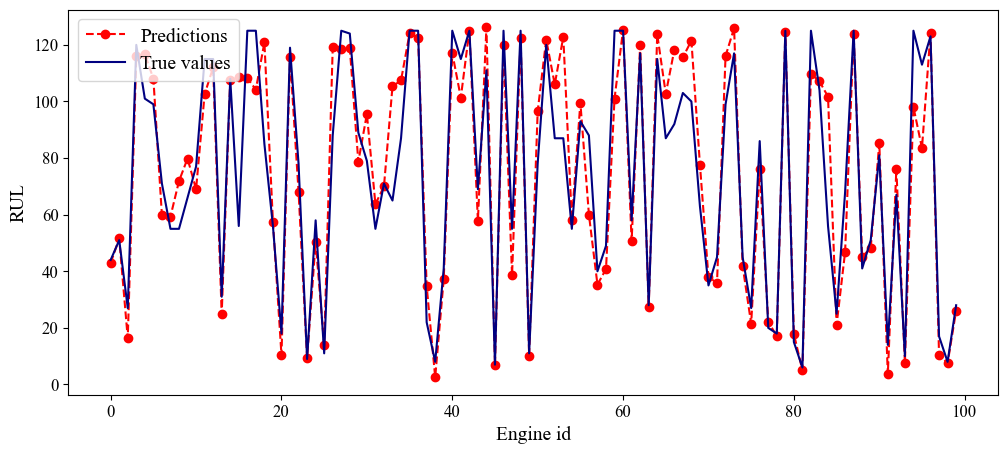

In [26]:
# 假设你已导入了数据并计算了模型输出
for data, target in test_loader:
    data, target = data.to('cpu'), target.to('cpu')
    outputs = model(data)
    
plt.rcParams['font.family'] = 'Times New Roman' #设置全局字体
# 设置图片大小
plt.figure(figsize=(12, 5))

index = np.argsort(target.detach().cpu().numpy())

# 绘制预测值，设置为红色虚线，圆点标记，指定圆点大小
plt.plot(outputs.detach().cpu().numpy(), 'r--o', label='Predictions', markersize=6)

# 绘制真实值，深蓝色实线
plt.plot(target.detach().cpu().numpy(), color='navy', label='True values')

# 设置字体，Times New Roman，和自定义字体大小
plt.xlabel('Engine id', fontsize=14, fontname='Times New Roman')
plt.ylabel('RUL', fontsize=14, fontname='Times New Roman')
# 设置坐标轴刻度的字体大小
plt.xticks(fontsize=12)  # 自定义横坐标轴字体大小
plt.yticks(fontsize=12)  # 自定义纵坐标轴字体大小

# 设置图例字体
plt.legend(prop={'size': 14, 'family': 'Times New Roman'})

# 设置图例字体和位置，位置为左下角
plt.legend(loc='upper left', fontsize=14)

plt.savefig('./result5_FD004.svg')

# 显示图像
plt.show()


In [21]:
len(data)

248

In [22]:
# model.eval()

In [23]:
result_1 = model(data[0].unsqueeze(0))

In [24]:
for data, target in test_loader:
    outputs = model(data)
result_1 = model(data[0].unsqueeze(0))

In [25]:
from scipy.stats import gaussian_kde

In [26]:

# 设置Dropout为启用状态
def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

# 设置模型中所有Dropout层的dropout率
def set_dropout_rate(model, dropout_rate):
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.p = dropout_rate
            

def get_prediction_list(model_path,learner,custom_dropout_rate = 0.5, sample_index = 1):
    # 加载模型
    learner.load_state_dict(torch.load(model_path))
    set_dropout_rate(learner, custom_dropout_rate)

    # 启用Dropout
    enable_dropout(learner)

    # 选择一个样本进行预测
    test_sample = data[sample_index].unsqueeze(0)

    # 设置MC Dropout采样次数
    n_samples = 100

    # 存储多次预测结果
    predictions = []

    # 进行多次预测
    for i in range(n_samples):
        output = learner(test_sample).detach().numpy()
        predictions.append(output)

    # 转换为NumPy数组
    predictions = np.array(predictions)

    # 计算均值和标准差
#     mean_prediction = predictions.mean(axis=0)
#     std_prediction = predictions.std(axis=0)
    return predictions


# 定义不同的核函数
def tophat_kernel(u):
    return 0.5 * (np.abs(u) <= 1)

def epanechnikov_kernel(u):
    return 0.75 * (1 - u**2) * (np.abs(u) <= 1)

def exponential_kernel(u):
    return 0.5 * np.exp(-np.abs(u))

# 核密度估计函数
def kde_with_kernel(data, kernel, bandwidth, x):
    kde_values = np.zeros_like(x)
    for xi in data:
        kde_values += kernel((x - xi) / bandwidth)
    return kde_values / (len(data) * bandwidth)

# 封装函数
def estimate_pdf(predictions, kernel, x_range):
    predictions = np.array(predictions).flatten()
    
    # 计算带宽
    kde = gaussian_kde(predictions, bw_method='scott')
    bandwidth = kde.factor * np.std(predictions)
    
    # 选择核函数
    if kernel == 'gaussian':
        pdf_estimator = gaussian_kde(predictions, bw_method='scott')
        x = np.linspace(0, x_range, 1000)
        pdf = pdf_estimator(x)
    else:
        x = np.linspace(0, x_range, 1000)
        if kernel == 'tophat':
            pdf = kde_with_kernel(predictions, tophat_kernel, bandwidth, x)
        elif kernel == 'epanechnikov':
            pdf = kde_with_kernel(predictions, epanechnikov_kernel, bandwidth, x)
        elif kernel == 'exponential':
            pdf = kde_with_kernel(predictions, exponential_kernel, bandwidth, x)
        else:
            raise ValueError("Unsupported kernel type. Choose from 'gaussian', 'tophat', 'epanechnikov', 'exponential'.")

    return x, pdf

In [116]:
learner = HybridNet()
model_path = './modelbest.pt'
custom_dropout_rate = 0.5
sample_index = 5
predictions = get_prediction_list(model_path,learner,custom_dropout_rate, sample_index)

kernel = 'gaussian'
# 'gaussian'  'tophat'  'epanechnikov'  'exponential'
x_range = 200
x, pdf = estimate_pdf(predictions, kernel, x_range)

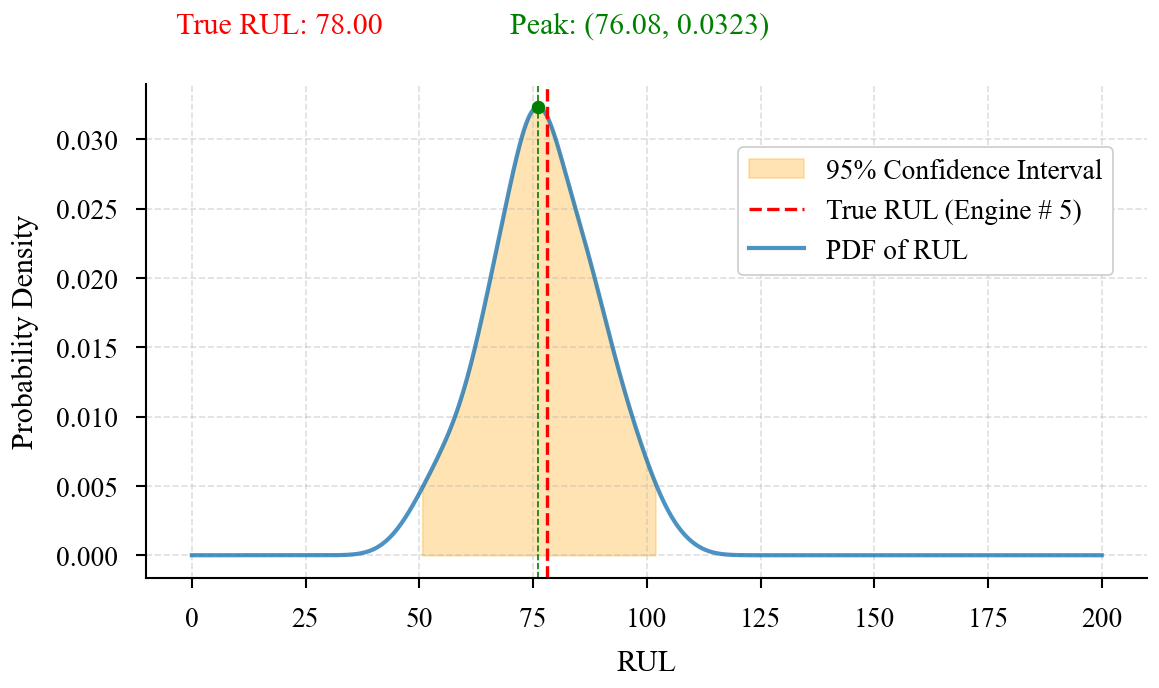

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from data_process import get_data  # 导入数据处理函数
from sklearn.metrics import r2_score
import torch

# 2. 图表风格设置
plt.style.use('seaborn-poster')
sns.set_context("notebook", font_scale=1.5)  # 调大字体
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.4,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# 3. 创建可视化图表
fig, ax = plt.subplots(figsize=(10, 6), dpi=120)

# 对 pdf 进行归一化处理，确保积分为 1
dx = x[1] - x[0]
integral = np.sum(pdf) * dx
normalized_pdf = pdf / integral

# 绘制预测密度曲线
ax.plot(x, normalized_pdf,
        linewidth=2.5,
        label='PDF of RUL',
        color='#1f77b4',
        alpha=0.8)

# model 是已经训练好的模型
# test_loader 是测试数据加载器

# 用于存储所有测试样本的真实 RUL 值
true_ruls = []

# 遍历测试数据加载器
for data, target in test_loader:
    # 存储真实 RUL 值
    true_ruls.extend(target.tolist())

# 指定要展示的样本编号
sample_index = 5  # 可以修改这个编号来展示不同的样本
if sample_index < len(true_ruls):
    true_rul = true_ruls[sample_index]
    # 添加真实 RUL 参考线
    ax.axvline(x=true_rul, color='red', linestyle='--', linewidth=2, label=f'True RUL (Engine # {sample_index})')
else:
    print("索引超出范围，请输入有效的编号。")

# 计算 95% 置信区间
cumulative_prob = np.cumsum(normalized_pdf) * dx
lower_bound_index = np.argmax(cumulative_prob >= 0.025)
upper_bound_index = np.argmax(cumulative_prob >= 0.975)
lower_bound = x[lower_bound_index]
upper_bound = x[upper_bound_index]

# 找出 pdf 的峰值
peak_index = np.argmax(normalized_pdf)
peak_value = normalized_pdf[peak_index]
peak_x = x[peak_index]

# 计算均值
mean = np.sum(x * normalized_pdf) * dx

# 在图中标注峰值点
ax.scatter(peak_x, peak_value, color='green', s=50, zorder=5)  # s 控制绿点大小，zorder 控制显示层级

# 将真实的 RUL 值和峰值（peak）值按顺序排列在图像上方空白处，且更紧凑
if sample_index < len(true_ruls):
    # 先绘制真实 RUL 值
    ax.text(0.25, 0.93, f'True RUL: {true_rul:.2f}',
            color='red', ha='center', va='bottom', fontsize=18, transform=fig.transFigure)
    # 再绘制 peak 值
    ax.text(0.55, 0.93, f'Peak: ({peak_x:.2f}, {peak_value:.4f})',
            color='green', ha='center', va='bottom', fontsize=18, transform=fig.transFigure)

# 绘制 PDF 峰值的虚线
ax.axvline(x=peak_x, color='green', linestyle='--', linewidth=1)

# 用橙色阴影表示 95% 置信区间，并添加 label 参数
confidence_interval_x = x[lower_bound_index:upper_bound_index + 1]
confidence_interval_pdf = normalized_pdf[lower_bound_index:upper_bound_index + 1]
ax.fill_between(confidence_interval_x, confidence_interval_pdf, color='orange', alpha=0.3, label='95% Confidence Interval')

# 4. 图表装饰
ax.set_xlabel('RUL', labelpad=10)
ax.set_ylabel('Probability Density', labelpad=10)

# 智能调整图例位置到坐标轴右侧
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], framealpha=1, loc='upper right', bbox_to_anchor=(0.98, 0.9))

plt.tight_layout()

plt.savefig('RUL_Uncertainty4_5.pdf', bbox_inches='tight')  # 保存为矢量图
plt.show()